# Analysis on how scalars evolve across age

- both before and after size normalization

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from toolz import sliding_window
from aging.util import correct_for_camera_height
from scipy.spatial.distance import pdist, squareform
from aging.plotting import figure, format_plots, save_factory, PlotConfig, add_identity

In [2]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "scalars-across-age", tight_layout=False)

In [3]:
version = 8
path = Path(f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_syllable_df_v00.parquet")
df = pd.read_parquet(path, engine="pyarrow")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18722870 entries, 0 to 18722869
Data columns (total 33 columns):
 #   Column          Dtype         
---  ------          -----         
 0   experiment      string        
 1   file            string        
 2   syllables       int16[pyarrow]
 3   date            datetime64[us]
 4   uuid            string        
 5   age             int64         
 6   true_depth      float[pyarrow]
 7   session_name    string        
 8   subject_name    string        
 9   timestamps      float[pyarrow]
 10  raw_timestamps  float[pyarrow]
 11  area_mm         float[pyarrow]
 12  area_px         float[pyarrow]
 13  centroid_x_mm   float[pyarrow]
 14  centroid_x_px   float[pyarrow]
 15  centroid_y_mm   float[pyarrow]
 16  centroid_y_px   float[pyarrow]
 17  height_ave_mm   float[pyarrow]
 18  length_mm       float[pyarrow]
 19  length_px       float[pyarrow]
 20  velocity_2d_mm  float[pyarrow]
 21  velocity_2d_px  float[pyarrow]
 22  velocity_3d_mm  

In [7]:
df["corrected_width"] = correct_for_camera_height(df["width_px"], df["true_depth"])
df["corrected_length"] = correct_for_camera_height(df["length_px"], df["true_depth"])
area = df["area_px"]
df["corrected_area"] = np.square(
    correct_for_camera_height(np.sqrt(area[area > 0]), df.loc[area > 0, "true_depth"])
)

In [8]:
df['corrected_velocity_2d'] = correct_for_camera_height(df['velocity_2d_px'], df['true_depth'])

In [9]:
pl_df = pl.DataFrame(
    df[
        [
            "age",
            "corrected_velocity_2d",
            "velocity_2d_px",
            "session_name",
            "uuid",
            "subject_name",
            "centroid_x_px",
            "centroid_y_px",
        ]
    ]
)
# fix velcoity calculation when there are many dropped frames
pl_df = pl_df.with_columns(
    (
        ~pl.col("corrected_velocity_2d").is_null().shift(1).fill_null(False)
        * pl.col("corrected_velocity_2d")
    )
).with_columns(
    pl.when(pl.col("corrected_velocity_2d") == 0)
    .then(None)
    .otherwise(pl.col("corrected_velocity_2d"))
    .name.keep()
)
# bin the velocities
n_bins = 25
pl_df = pl_df.with_columns(
    pl.col("corrected_velocity_2d")
    .cut(
        np.linspace(0, 5, n_bins + 1),
        labels=["low"]
        + [str(np.mean(f)) for f in sliding_window(2, np.linspace(0, 5, n_bins + 1))]
        + ["high"],
    )
    .alias("bins")
)

# add distance to center
pl_df = (
    pl_df.lazy()
    .with_columns(
        (
            pl.col("centroid_x_px")
            - (pl.col("centroid_x_px").max() - pl.col("centroid_x_px").min()) / 2
        ).over("uuid"),
        (
            pl.col("centroid_y_px")
            - (pl.col("centroid_y_px").max() - pl.col("centroid_y_px").min()) / 2
        ).over("uuid"),
    )
    .with_columns(
        (pl.col("centroid_x_px") ** 2 + pl.col("centroid_y_px") ** 2)
        .sqrt()
        .alias("distance_to_center")
    )
    .with_columns(
        pl.col("distance_to_center")
        .cut(
            np.linspace(0, 140, n_bins + 1),
            labels=["low"]
            + [
                str(np.mean(f))
                for f in sliding_window(2, np.linspace(0, 140, n_bins + 1))
            ]
            + ["high"],
        )
        .alias("distance_bins")
    )
    .collect()
)

In [10]:
grouping = pl_df.group_by("age").agg(pl.col("bins").value_counts())

In [17]:
vel_hist = {}

for age, row in grouping.iter_rows():
    out = {}
    for item in row:
        if item["bins"] in (None, "low", "high"):
            continue
        out[round(float(item["bins"]) * 30, 1)] = item["count"]
    vel_hist[age] = out

In [18]:
vel_hist_df = pd.DataFrame(vel_hist).T
vel_hist_df.columns.name = "Speed (px/s)"
vel_hist_df.index.name = "Age (weeks)"
vel_hist_df = vel_hist_df.sort_index().sort_index(axis='columns')
vel_hist_df = vel_hist_df / vel_hist_df.sum(axis=1).values[:, None]

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


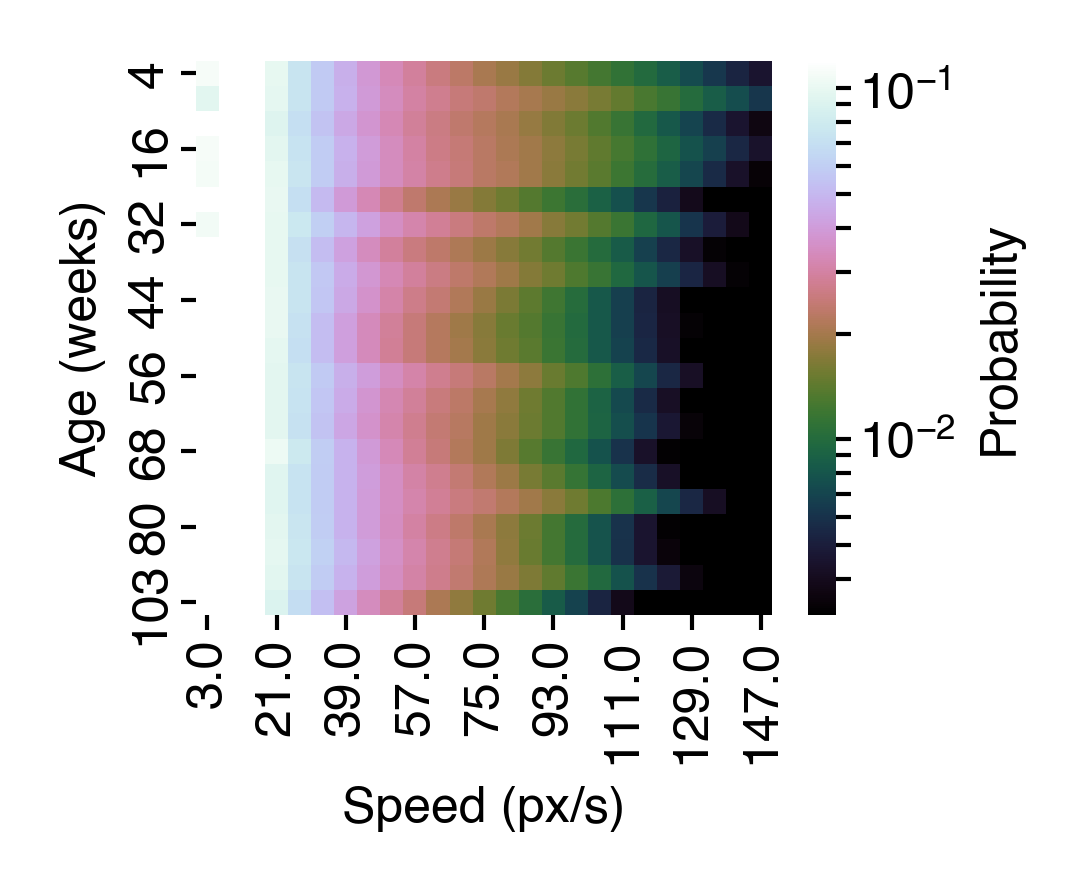

In [19]:
fig = figure(1.55, 1.2)
ax = sns.heatmap(
    vel_hist_df.clip(10 ** (-2.5), 0.12),
    cmap="cubehelix",
    cbar_kws={"label": "Probability"},
    norm="log",
)
# saver(fig, "velocity-histogram-across-age");

<Axes: xlabel='Age (weeks)'>

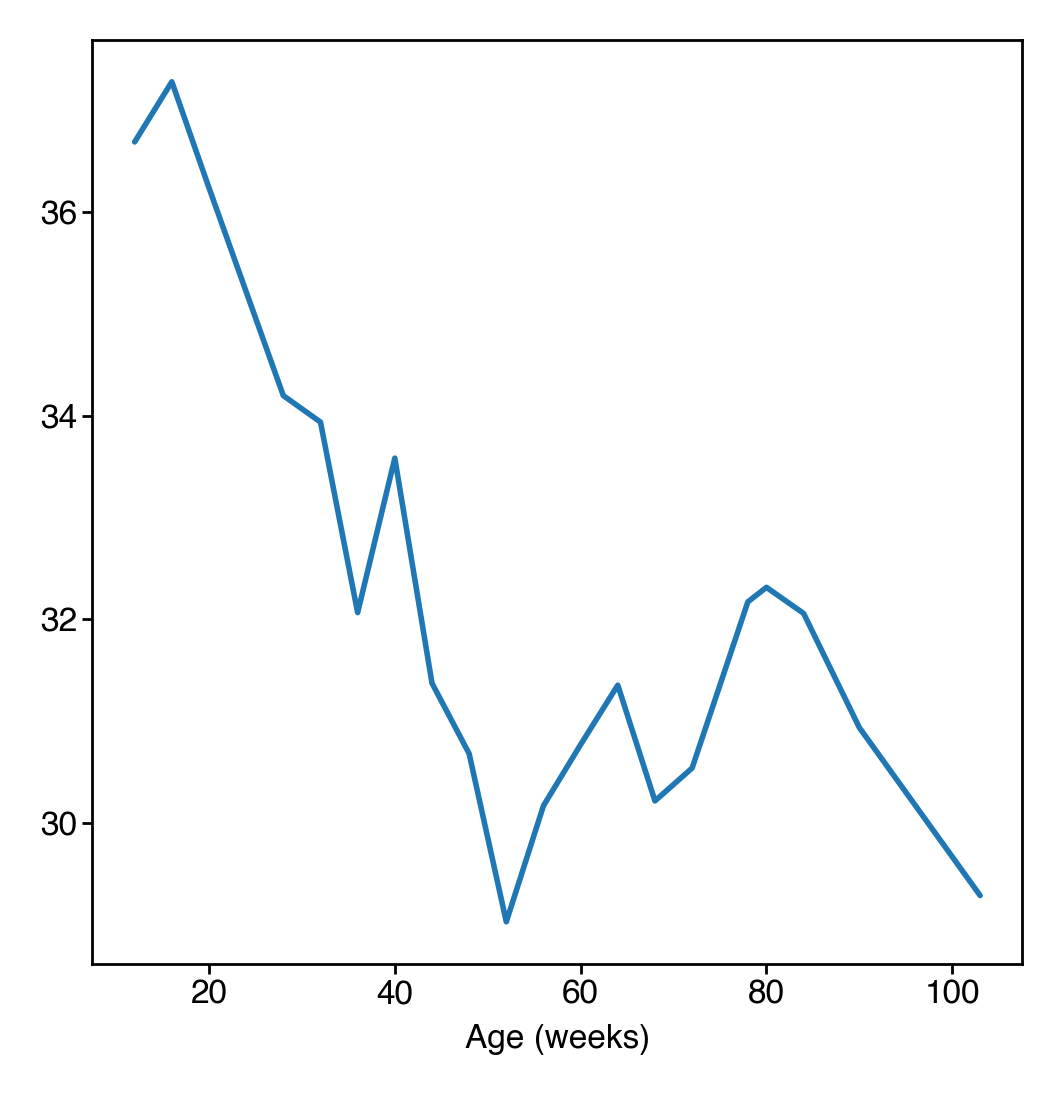

In [20]:
(vel_hist_df * vel_hist_df.columns.to_numpy()[None]).sum(1).rolling(3).mean().plot()

In [21]:
mean_velocities = (
    pl_df.lazy()
    .filter(pl.col("corrected_velocity_2d").is_between(0, 5, closed="none"))
    .group_by(["age", "uuid"])
    .agg(pl.mean("corrected_velocity_2d") * 30)
).collect()

<Axes: xlabel='age', ylabel='corrected_velocity_2d'>

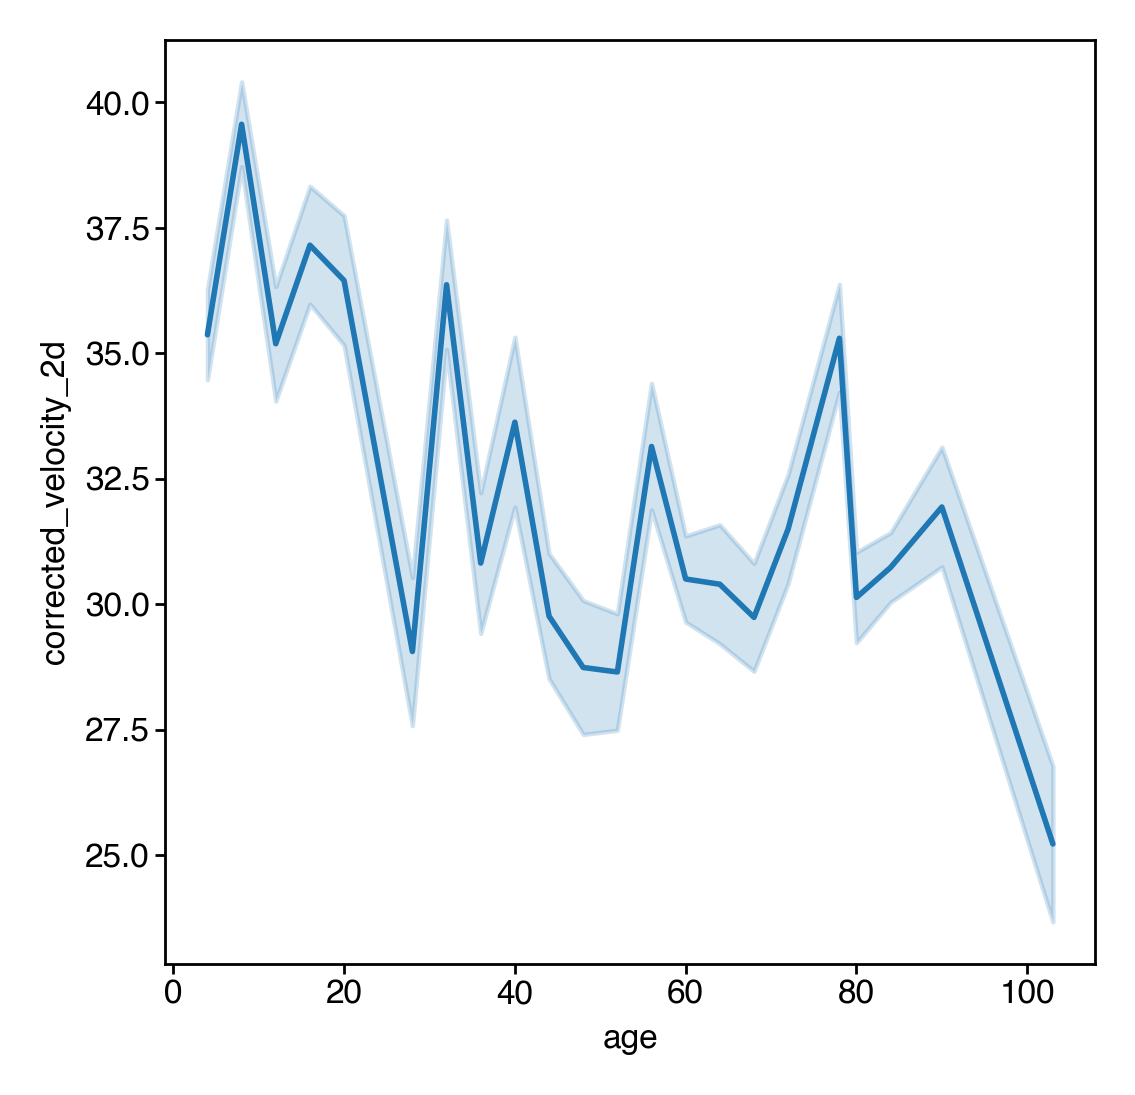

In [22]:
sns.lineplot(data=mean_velocities, x='age', y='corrected_velocity_2d', errorbar='se')

In [23]:
high_velocities = (
    pl_df.lazy()
    .filter(pl.col("corrected_velocity_2d").is_between(0, 5, closed="none"))
    .group_by(["age", "uuid"])
    .agg(pl.col("corrected_velocity_2d").quantile(0.95) * 30)
).collect()

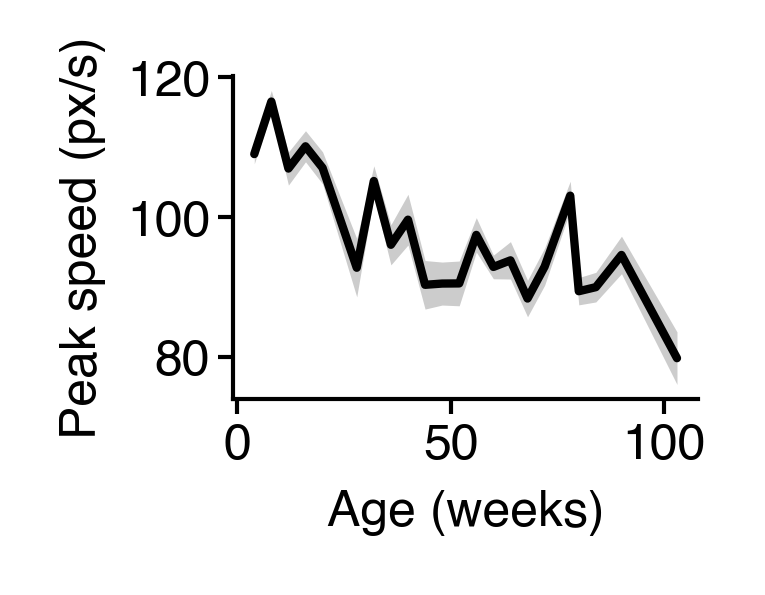

In [24]:
fig = figure(1, 0.7)
ax = sns.lineplot(
    data=high_velocities,
    x="age",
    y="corrected_velocity_2d",
    errorbar="se",
    err_kws={"lw": 0},
    c="k",
    lw=1
)
ax.set(ylabel="Peak speed (px/s)", xlabel="Age (weeks)")
sns.despine()
# saver(fig, "peak-speed-across-age");

[Text(0.5, -9.575000000000005, 'Age (weeks)'),
 Text(6.624999999999995, 0.5, 'Age (weeks)')]

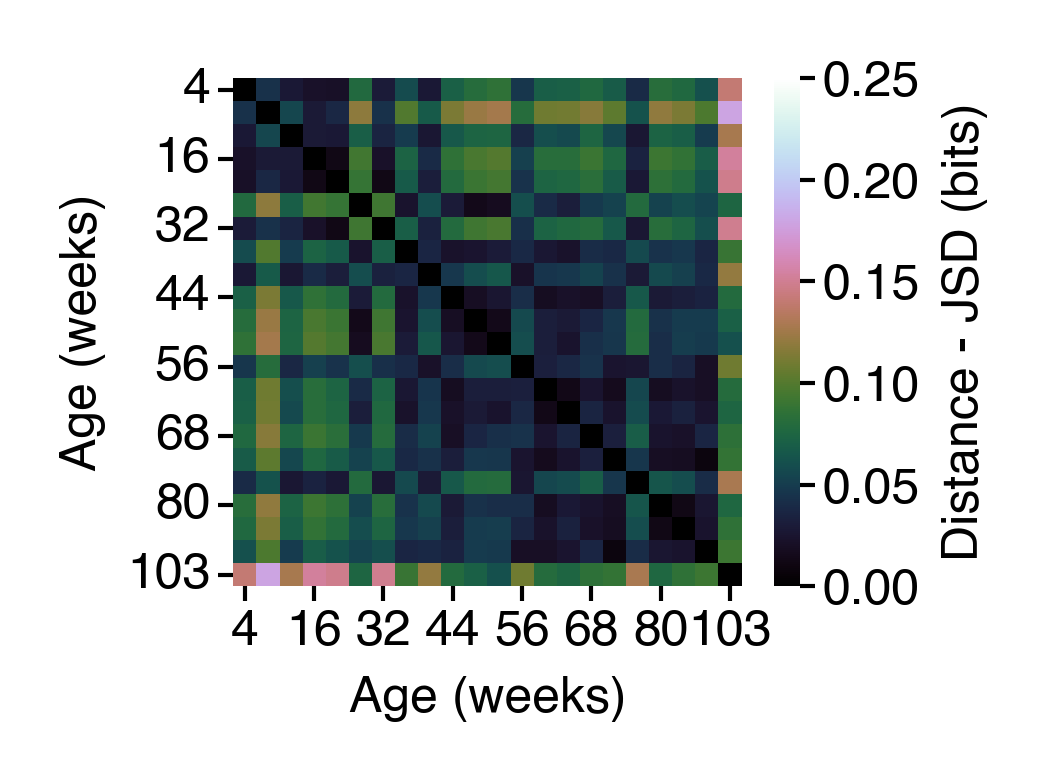

In [25]:
vel_dists = squareform(pdist(vel_hist_df.fillna(0), metric="jensenshannon"))
vel_dists = pd.DataFrame(vel_dists, columns=vel_hist_df.index, index=vel_hist_df.index)

fig = figure(1.4, 1.1)
ax = sns.heatmap(
    vel_dists,
    cmap="cubehelix",
    vmin=0,
    vmax=0.25,
    cbar_kws=dict(label="Distance - JSD (bits)"),
)
ax.set_aspect("equal")
ax.set(xlabel="Age (weeks)", ylabel="Age (weeks)")
# saver(fig, "velocity-histogram-distance-mtx");

## Group by individual session

In [26]:
grouping = pl_df.group_by(["age", "uuid"]).agg(pl.col("bins").value_counts())

In [28]:
indiv_vel_hist = {}

for age, uuid, row in grouping.iter_rows():
    out = {}
    for item in row:
        if item['bins'] in (None, 'low', 'high'):
            continue
        out[round(float(item['bins']) * 30, 1)] = item['count']
    indiv_vel_hist[(age, uuid)] = out

In [29]:
indiv_vel_hist_df = pd.DataFrame(indiv_vel_hist).T.fillna(0)
indiv_vel_hist_df.columns.name = "Speed (px/s)"
indiv_vel_hist_df.index.rename(["Age (weeks)", "UUID"], inplace=True)
indiv_vel_hist_df = indiv_vel_hist_df.sort_index().sort_index(axis='columns')
indiv_vel_hist_df = indiv_vel_hist_df / indiv_vel_hist_df.sum(axis=1).values[:, None]

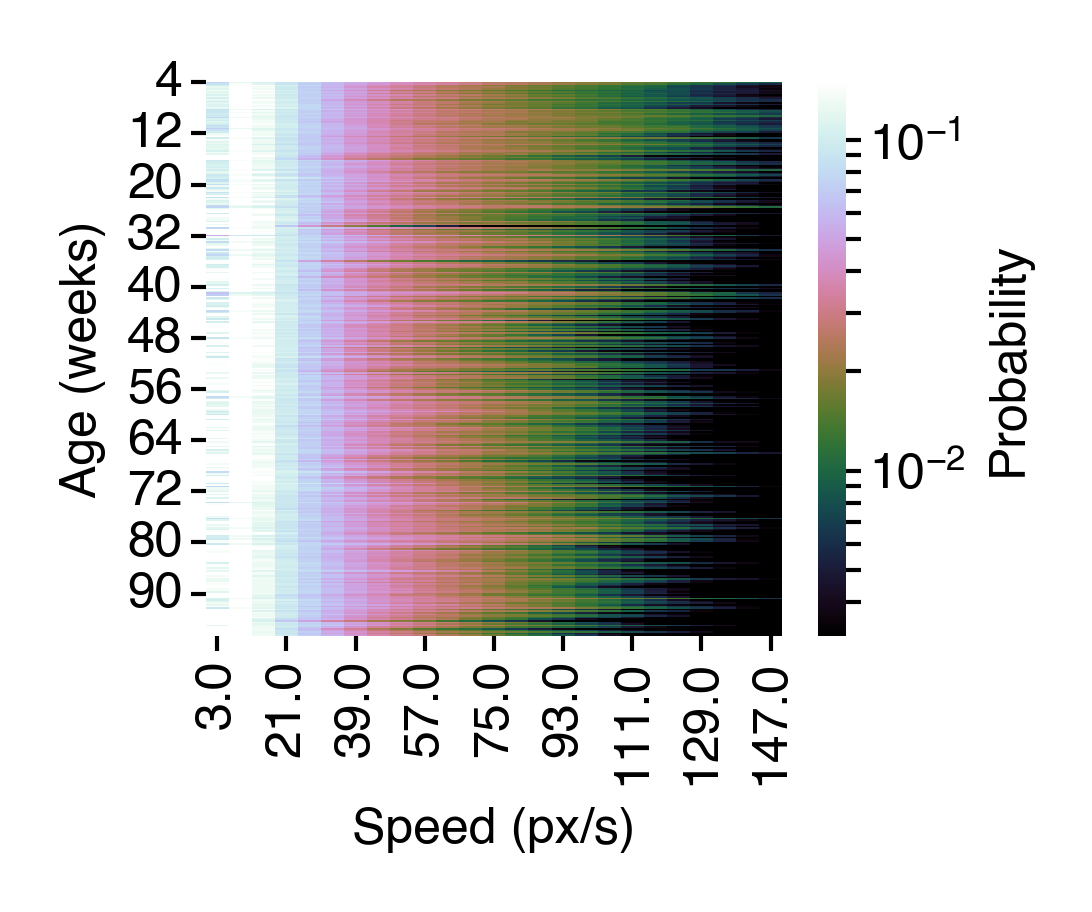

In [30]:
fig = figure(1.55, 1.2)
ax = sns.heatmap(
    indiv_vel_hist_df.fillna(1e-6).clip(10 ** (-2.5), 0.15).droplevel(1),
    cmap="cubehelix",
    cbar_kws={"label": "Probability"},
    norm="log",
)
# saver(fig, "individual-velocity-histogram-across-age");

[Text(0.5, -9.575000000000005, 'Sessions'),
 Text(6.624999999999995, 0.5, 'Sessions'),
 None]

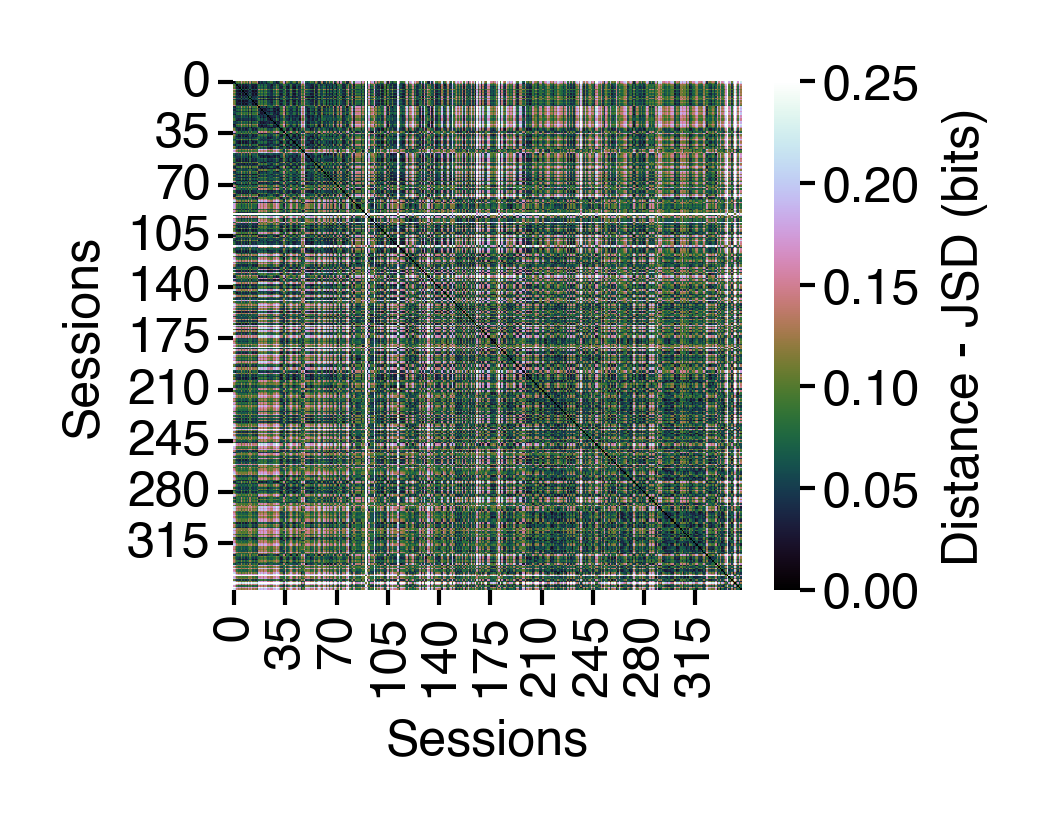

In [31]:
vel_dists = squareform(pdist(indiv_vel_hist_df.fillna(0), metric="jensenshannon"))

fig = figure(1.4, 1.1)
ax = sns.heatmap(
    vel_dists,
    cmap="cubehelix",
    vmin=0,
    vmax=0.25,
    cbar_kws=dict(label="Distance - JSD (bits)"),
    rasterized=True,
)
ax.set(xlabel="Sessions", ylabel="Sessions", aspect="equal")
# saver(fig, "individual-velocity-histogram-distance-mtx", dpi=600);

## Distance to center

In [33]:
dist_grouping = pl_df.group_by("age").agg(pl.col("distance_bins").value_counts())
dist_hist = {}

for age, row in dist_grouping.iter_rows():
    out = {}
    for item in row:
        if item['distance_bins'] in (None, 'low', 'high'):
            continue
        out[round(float(item['distance_bins']), 1)] = item['count']
    dist_hist[age] = out

In [34]:
dist_hist_df = pd.DataFrame(dist_hist).T.fillna(0)
dist_hist_df.columns.name = "Distance to center (px)"
dist_hist_df.index.name = "Age (weeks)"
dist_hist_df = dist_hist_df.sort_index().sort_index(axis='columns')
dist_hist_df = dist_hist_df / dist_hist_df.sum(axis=1).values[:, None]

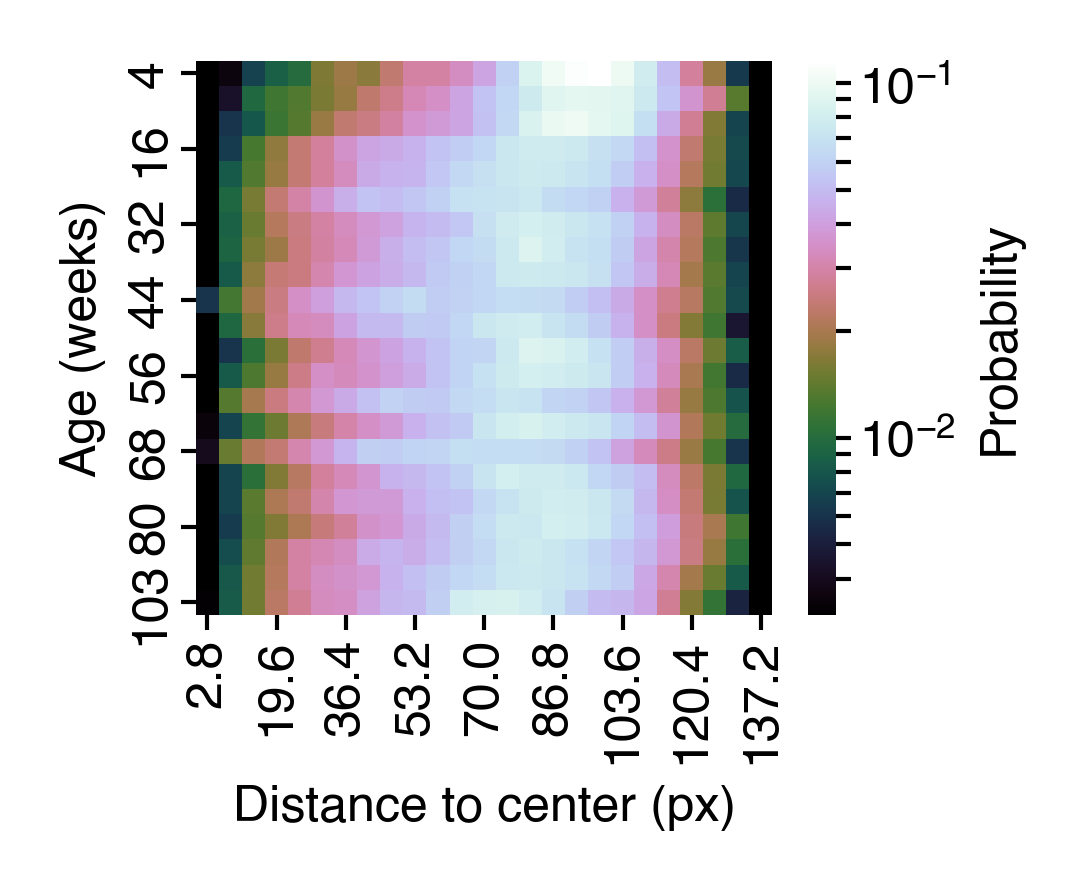

In [35]:
fig = figure(1.55, 1.2)
ax = sns.heatmap(
    dist_hist_df.clip(10 ** (-2.5), 0.12),
    cmap="cubehelix",
    cbar_kws={"label": "Probability"},
    norm="log",
)
# saver(fig, "center-dist-histogram-across-age");

[Text(0.5, -9.575000000000005, 'Age (weeks)'),
 Text(6.624999999999995, 0.5, 'Age (weeks)'),
 None]

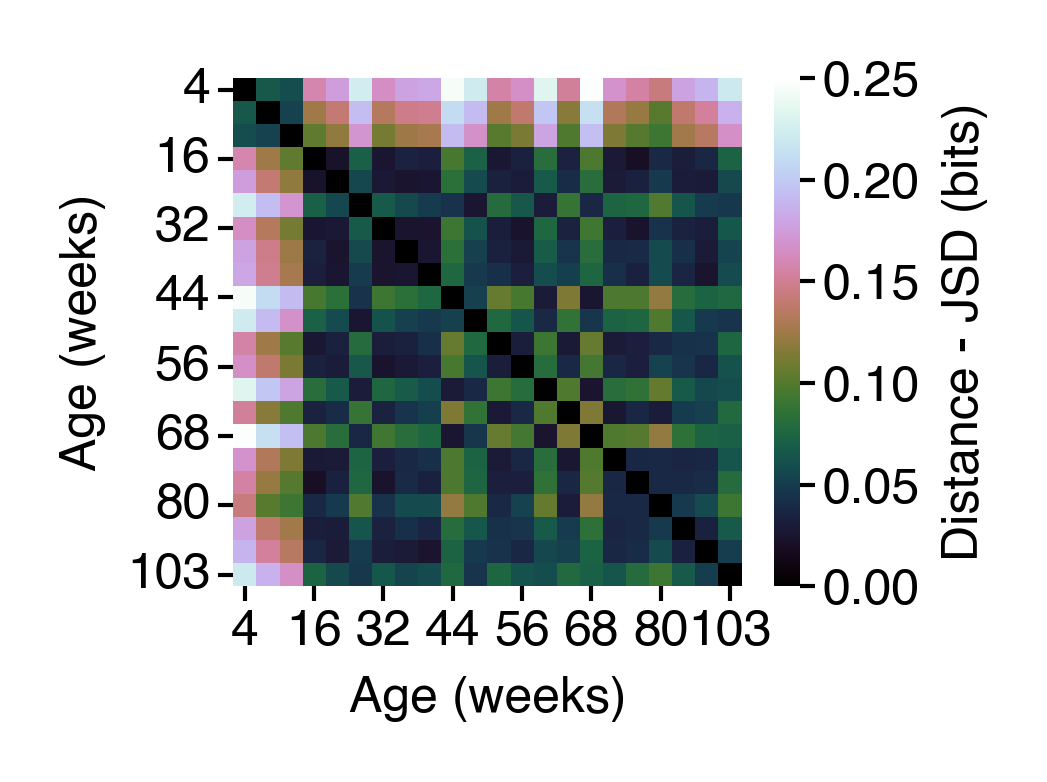

In [36]:
dist_dists = squareform(pdist(dist_hist_df, metric="jensenshannon"))
dist_dists = pd.DataFrame(dist_dists, columns=dist_hist_df.index, index=dist_hist_df.index)

fig = figure(1.4, 1.1)
ax = sns.heatmap(
    dist_dists,
    cmap="cubehelix",
    vmin=0,
    vmax=0.25,
    cbar_kws=dict(label="Distance - JSD (bits)"),
)
ax.set(xlabel="Age (weeks)", ylabel="Age (weeks)", aspect="equal")
# saver(fig, "center-dist-histogram-distance-mtx");

## Combine velocity and dist to center, classify/regress age

In [38]:
dist_grouping = pl_df.group_by(["age", "uuid"]).agg(pl.col("distance_bins").value_counts())
dist_hist = {}

for age, uuid, row in dist_grouping.iter_rows():
    out = {}
    for item in row:
        if item['distance_bins'] in (None, 'low', 'high'):
            continue
        out[round(float(item['distance_bins']), 1)] = item['count']
    dist_hist[(age, uuid)] = out

In [39]:
indiv_dist_hist_df = pd.DataFrame(dist_hist).T.fillna(0)
indiv_dist_hist_df.columns.name = "Distance to Center (px)"
indiv_dist_hist_df.index.rename(["Age (weeks)", "UUID"], inplace=True)
indiv_dist_hist_df = indiv_dist_hist_df.sort_index().sort_index(axis='columns')
indiv_dist_hist_df = indiv_dist_hist_df / indiv_dist_hist_df.sum(axis=1).values[:, None]

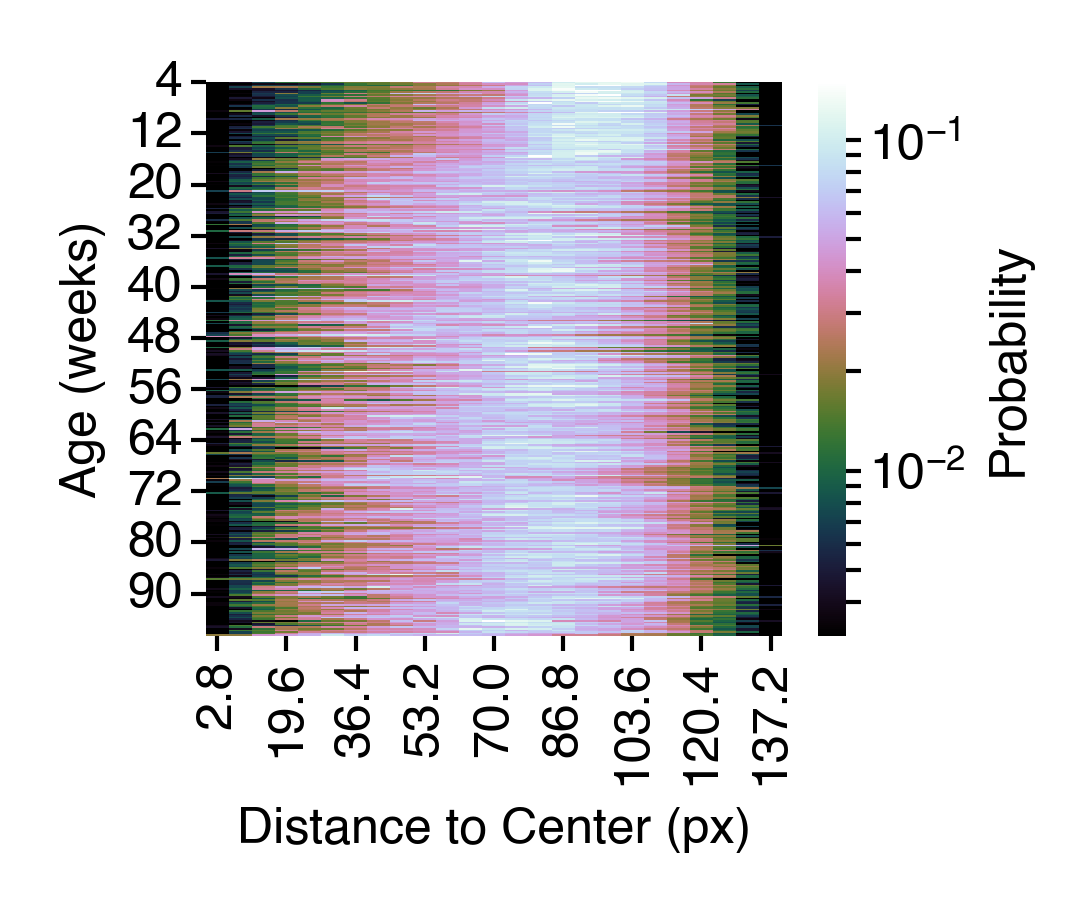

In [41]:
fig = figure(1.55, 1.2)
ax = sns.heatmap(
    indiv_dist_hist_df.fillna(1e-6).clip(10 ** (-2.5), 0.15).droplevel(1),
    cmap="cubehelix",
    cbar_kws={"label": "Probability"},
    norm="log",
)
# saver(fig, "individual-center-dist-histogram-across-age");

[Text(0.5, -9.575000000000005, 'Sessions'),
 Text(6.624999999999995, 0.5, 'Sessions'),
 None]

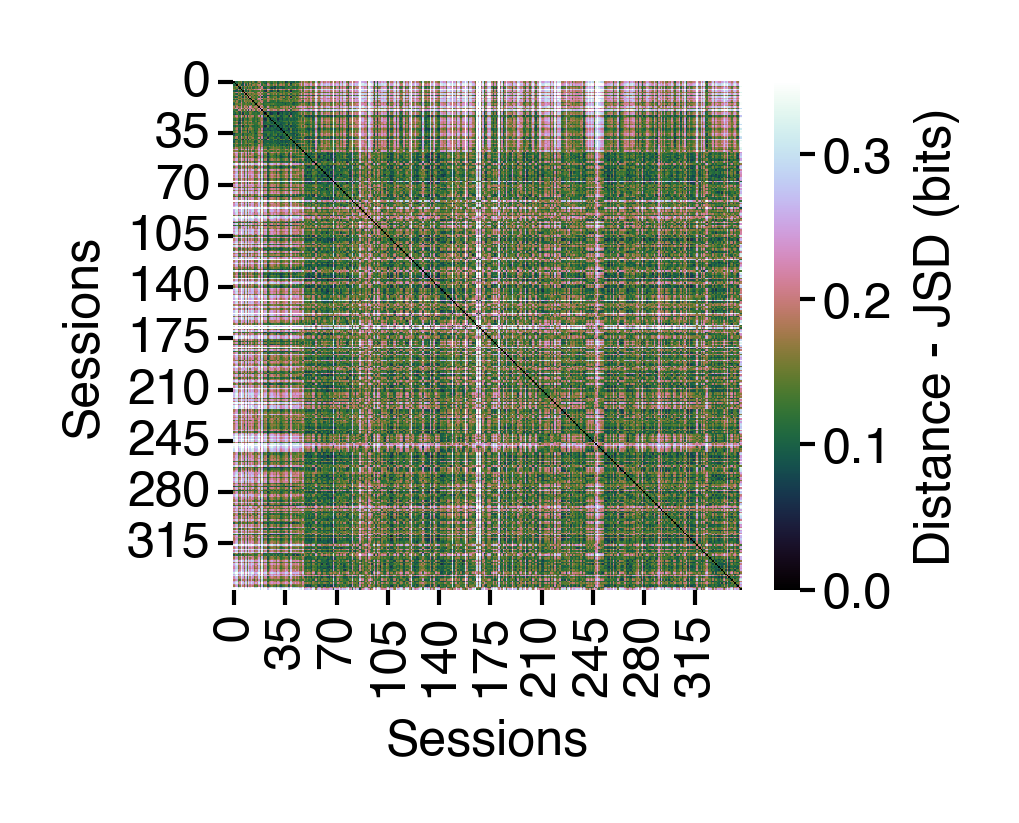

In [42]:
dist_dists = squareform(pdist(indiv_dist_hist_df.fillna(0), metric="jensenshannon"))

fig = figure(1.4, 1.1)
ax = sns.heatmap(
    dist_dists,
    cmap="cubehelix",
    vmin=0,
    vmax=0.35,
    cbar_kws=dict(label="Distance - JSD (bits)"),
    rasterized=True,
)
ax.set(xlabel="Sessions", ylabel="Sessions", aspect="equal")
# saver(fig, "individual-center-dist-histogram-distance-mtx", dpi=600);

In [43]:
combined_data = pd.concat([indiv_dist_hist_df, indiv_vel_hist_df], axis=1).fillna(0)

In [44]:
# StratifiedKFold classifer first
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GroupKFold, LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

In [45]:
ages = combined_data.index.get_level_values(0).values

In [46]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [47]:
scores = cross_val_score(
    pipeline,
    combined_data,
    ages,
    # cv=StratifiedKFold(n_splits=5),
    cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=10),
)
scores

array([0.20689655, 0.17241379, 0.17241379, 0.1627907 , 0.1954023 ,
       0.12643678, 0.27586207, 0.19767442, 0.14942529, 0.1954023 ,
       0.24137931, 0.19767442, 0.22988506, 0.1954023 , 0.13793103,
       0.20930233, 0.1954023 , 0.16091954, 0.24137931, 0.19767442,
       0.20689655, 0.2183908 , 0.25287356, 0.22093023, 0.20689655,
       0.25287356, 0.24137931, 0.13953488, 0.2183908 , 0.22988506,
       0.14942529, 0.25581395, 0.28735632, 0.20689655, 0.17241379,
       0.12790698, 0.12643678, 0.26436782, 0.17241379, 0.1627907 ])

In [48]:
scores = cross_val_score(
    RandomForestClassifier(),
    combined_data,
    combined_data.index.get_level_values(0),
    # cv=StratifiedKFold(n_splits=5),
    cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=3),
)
scores

array([0.16091954, 0.20689655, 0.20689655, 0.24418605, 0.17241379,
       0.26436782, 0.2183908 , 0.23255814, 0.16091954, 0.2183908 ,
       0.14942529, 0.20930233])

In [49]:
# regression form
pipeline = make_pipeline(StandardScaler(), PLSRegression(n_components=5))
preds = cross_val_predict(
    pipeline,
    combined_data,
    combined_data.index.get_level_values(0),
    cv=LeaveOneGroupOut(),
    groups=LabelEncoder().fit_transform(combined_data.index.get_level_values(0)).squeeze(),
)
r2_score(ages, preds)

0.4997546844326408

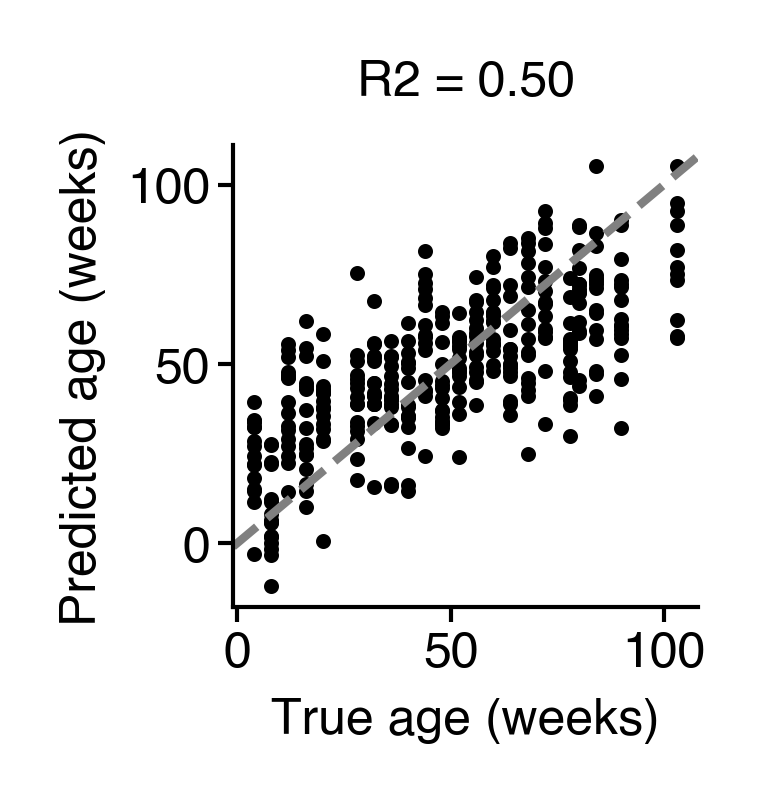

In [50]:
r2 = r2_score(ages, preds)

fig = figure(1, 1)
ax = fig.gca()
ax.scatter(ages, preds, s=1, c='k')
add_identity(ax, color='gray', ls='--')
ax.set(title=f"R2 = {r2:.2f}", xlabel="True age (weeks)", ylabel="Predicted age (weeks)")
sns.despine()
# saver(fig, "age-prediction-from-scalars");